### Libraries

In [175]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

### Functions

In [2]:
def create_procentaje_nan(df) -> pd.DataFrame:
    """Create a dataframe with nan porcertage values by column"""
    nan_columns = pd.DataFrame(df.isna().sum() * 100 / len(df))
    nan_columns.reset_index(inplace = True)
    nan_columns.columns = ["Column", "Number_values"]
    nan_columns.sort_values("Number_values", ascending=False, inplace=True)
    return nan_columns


def drop_miscolumns(df, portentage_miss) -> pd.DataFrame:
    """Return dataframe with columns with less portentage_miss"""
    df_copy = df.copy()
    porcentage_missv = pd.DataFrame(df_copy.isna().sum() * 100 / len(df))
    porcentage_missv.reset_index(inplace = True)
    porcentage_missv.columns = ["Columns", "Percentage"]
    porcentage_missv.sort_values("Percentage", ascending=False, inplace=True)
    mask = porcentage_missv.Percentage >= portentage_miss
    list_del = porcentage_missv[mask].Columns.values
    df_copy.drop(columns = list_del, inplace = True)
    return df_copy


def create_df_bydatatype(df_) -> pd.DataFrame:
    """Create DataFrame By type"""
    df_funcion = df_.copy()
    list_objects2 = list(df_funcion.select_dtypes(include=["object"]).columns)
    print(f"List objects type------------------------------------------------")
    print(list_objects2)
    print()
    print(f"List float type---------------------------------------------------")
    list_float2 = list(df_funcion.select_dtypes(include=["float64"]).columns)
    print(list_float2)
    print()
    print(f"List int type------------------------------------------------------")
    list_int2 = list(df_funcion.select_dtypes(include=["int64"]).columns)
    print(list_int2)
    print()
    return df_funcion[list_objects2], df_funcion[list_float2], df_funcion[list_int2] 


In [283]:
df_origin = pd.read_csv("/home/aldair913/Documents/coursera/Data-Collisions.csv",  low_memory=False)
df_origin.drop(columns = ["SEVERITYCODE.1"], inplace = True)

"""CHANGE CATEGORI 2 to 0 for convenience
•2—injury       -> 0 injury
•1—prop damage  -> 1 propdamage
        """

df_origin.replace({2 : 0}, inplace = True)


X = df_origin.drop(columns = "SEVERITYCODE")
y = df_origin["SEVERITYCODE"]

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
undersamp = RandomUnderSampler(random_state=1)

df, df_severity = undersamp.fit_resample(df_train, y_train)

df["SEVERITYCODE"] = df_severity

In [284]:
print("Original Features Set Shape : ", df_origin.shape)
print("Original Severity Code Set Shape : ", df_origin["SEVERITYCODE"].shape)
print("Train Features Set Shape : ", df_train.shape)
print("Train Severity Code Set Shape : ", y_train.shape)
print("Test Features Set Shape : ", df_test.shape)
print("Test Severity Code Set Shape : ", y_test.shape)

Original Features Set Shape :  (194673, 37)
Original Severity Code Set Shape :  (194673,)
Train Features Set Shape :  (136271, 36)
Train Severity Code Set Shape :  (136271,)
Test Features Set Shape :  (58402, 36)
Test Severity Code Set Shape :  (58402,)


1    40877
0    40877
Name: SEVERITYCODE, dtype: int64


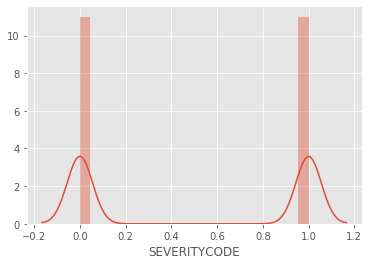

In [285]:
print(df["SEVERITYCODE"].value_counts())
sns.distplot(df["SEVERITYCODE"], hist=True)

In [286]:
create_procentaje_nan(df).head(8)

,Column,Number_values
11,EXCEPTRSNDESC,97.744453
28,PEDROWNOTGRNT,96.257064
30,SPEEDING,94.867529
23,INATTENTIONIND,83.869902
8,INTKEY,62.447097
10,EXCEPTRSNCODE,55.461506
29,SDOTCOLNUM,41.492771
20,JUNCTIONTYPE,2.522201


### Deleting 7 columns with more than 40% nan values

In [147]:
df = drop_miscolumns(df, 40)
df.dropna(inplace = True)
create_procentaje_nan(df).head()

,Column,Number_values
0,X,0.0
1,Y,0.0
28,HITPARKEDCAR,0.0
27,CROSSWALKKEY,0.0
26,SEGLANEKEY,0.0


In [149]:
print("Final Shape Train Set", df.shape)

Final Shape Train Set (76458, 30)


### Creating a DataFrame By type

In [155]:
df_objects, df_float, df_int = create_df_bydatatype(df)

List objects type------------------------------------------------
['REPORTNO', 'STATUS', 'ADDRTYPE', 'LOCATION', 'SEVERITYDESC', 'COLLISIONTYPE', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLDESC', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'ST_COLCODE', 'ST_COLDESC', 'HITPARKEDCAR']

List float type---------------------------------------------------
['X', 'Y']

List int type------------------------------------------------------
['OBJECTID', 'INCKEY', 'COLDETKEY', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'SDOT_COLCODE', 'SEGLANEKEY', 'CROSSWALKKEY', 'SEVERITYCODE']



### Int Types

### Droping Identifiers and Keys, they are no relevant features

In [159]:
df_int.drop(columns = ["OBJECTID", "INCKEY", "COLDETKEY", "SEGLANEKEY", "CROSSWALKKEY"], inplace=True)

### Selecting the best features in the dataset

Feature 0: 1958.091869
Feature 1: 3786.549647
Feature 2: 2765.581130
Feature 3: 1895.931997
Feature 4: 2152.334807


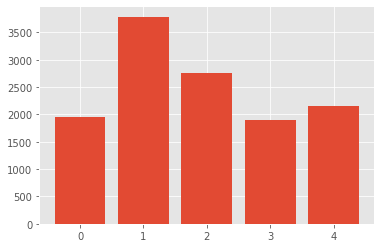

In [287]:
X_train_int = df_int.drop(columns= "SEVERITYCODE").values
y_train_int = df_int["SEVERITYCODE"].values

def select_intbest(X, y):
    fs = SelectKBest(score_func=f_classif, k = "all")
    fs.fit(X, y)
    X_train_fs = fs.transform(X)
    return X_train_fs, fs

X_int_values, fs = select_intbest(X_train_int, y_train_int)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

### We can see that all the final features have some relevance

In [20]:
## Value by column
def create_df_KBest(df, fs) -> pd.DataFrame:
    df_features = df.copy()
    values = pd.DataFrame(fs.scores_)
    values["columns"] = df_features.drop(columns= "SEVERITYCODE").columns
    values.sort_values(by = 0, ascending=False, inplace = True)
    return values

In [24]:
list_int_final = create_df_KBest(df_int, fs)["columns"].values
create_df_KBest(df_int, fs)

,0,columns
1,3786.549647,PEDCOUNT
2,2765.581130,PEDCYLCOUNT
4,2152.334807,SDOT_COLCODE
0,1958.091869,PERSONCOUNT
3,1895.931997,VEHCOUNT


In [28]:
df_int = df[list_int_final]
#df_int["SEVERITYCODE"] = y_train_int
#df_int

### Int columns
* PEDCOUNT
* PEDCYLCOUNT
* SDOT_COLCODE
* PERSONCOUNT
* VEHCOUNT

In [162]:
#for i in range(0, len(df_int.columns)):
#print(df_int.iloc[:, i].value_counts())
#    print("-----------------------------------")

### Categorical Types

### The same process for categorical Features

In [29]:
drop_object = ["REPORTNO", "INCDATE", "INCDTTM", "ST_COLDESC", "STATUS", "SEVERITYDESC", "SEVERITYDESC", "SDOT_COLDESC"]
df_objects.drop(columns = drop_object, inplace  = True)
df_objects["UNDERINFL"].replace({"0" : "N", "1" : "Y"}, inplace = True)

In [163]:
df_objects.head(1)

,REPORTNO,STATUS,ADDRTYPE,LOCATION,SEVERITYDESC,COLLISIONTYPE,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLDESC,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE,ST_COLDESC,HITPARKEDCAR
0,1793317,Matched,Block,W NICKERSON ST BETWEEN 8TH AVE W AND XW JESSE ...,Injury Collision,Rear Ended,2005/05/01 00:00:00+00,5/1/2005,Mid-Block (not related to intersection),"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",1,Clear,Dry,Dark - Street Lights On,14,From same direction - both going straight - on...,N


In [31]:
df_objects["SEVERITYCODE"] = df["SEVERITYCODE"]
X_train_obj  = df_objects.drop(columns = ["SEVERITYCODE"]).values
X_train_obj  = X_train_obj.astype("str")
y_train_obj = df_objects["SEVERITYCODE"].values

In [289]:
def prepare_inputs(X_train):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    return X_train_enc

def prepare_target(y):
    oe = LabelEncoder()
    oe.fit(y)
    y_train_enc = oe.transform(y)
    return y_train_enc

X_obj_enc = prepare_inputs(X_train_obj)
y_obj_enc = prepare_target(y_train_obj)

In [34]:
fs_obj = SelectKBest(score_func=chi2, k='all')
fs_obj.fit(X_obj_enc, y_obj_enc)
#X_fs = fs.transform(X_obj_enc)

SelectKBest(k='all', score_func=<function chi2 at 0x7fa772102b90>)

In [38]:
# what are scores for the features
#for i in range(len(fs_obj.scores_)):
#    print('Feature %d: %f' % (i, fs_obj.scores_[i]))
# plot the scores
#pyplot.bar([i for iin range(len(fs_obj.scores_))], fs_obj.scores_)
#pyplot.show()

In [39]:
chi_test = pd.DataFrame(fs_obj.scores_)
chi_test["columns"] = df_objects.drop(columns = ["SEVERITYCODE"]).columns
chi_test.sort_values(by = 0, ascending=False, inplace = True)
chi_test

,0,columns
1,334899.506558,LOCATION
8,20172.081625,ST_COLCODE
3,2715.949460,JUNCTIONTYPE
2,2699.687458,COLLISIONTYPE
5,1986.146666,WEATHER
0,1978.872977,ADDRTYPE
9,988.054721,HITPARKEDCAR
6,709.669069,ROADCOND
4,143.412250,UNDERINFL
7,119.108385,LIGHTCOND


#### Object Columns
* LOCATION
* ST_COLCODE
* JUNCTIONTYPE
* COLLISIONTYPE
* WEATHER
* ADDRTYPE

In [42]:
object_final_lt = chi_test["columns"][0:6].values
df_objects = df_objects[object_final_lt]
df_objects["SEVERITYCODE"] = df["SEVERITYCODE"]

df_test["SEVERITYCODE"] = y_test
create_procentaje_nan(df_test)
df_test = drop_miscolumns(df_test, 35)
df_test.dropna(inplace = True)

In [168]:
#for i in range(0, len(df_objects.columns)):
#print(df_objects.iloc[:, i].value_counts())
#    print("-----------------------------------")

In [32]:
#df_test[object_final_lt]

In [44]:
X_train_obj = df_objects.drop(columns = "SEVERITYCODE").values
y_train_obj = df_objects["SEVERITYCODE"].values

X_test_obj = df_test[object_final_lt].values
y_test_obj = df_test["SEVERITYCODE"].values

X_train_obj = prepare_inputs(X_train_obj)
X_test_obj = prepare_inputs(X_test_obj)

y_train_obj = prepare_target(y_train_obj)
y_test_obj = prepare_target(y_test_obj)

### INT + OBJECTS

In [51]:
X_train_obj = df_objects.drop(columns = "SEVERITYCODE").values
y_train_obj = df_objects["SEVERITYCODE"].values

X_test_obj = df_test[object_final_lt].values
y_test_obj = df_test["SEVERITYCODE"].values

X_train_obj = prepare_inputs(X_train_obj)
X_test_obj = prepare_inputs(X_test_obj)

y_train_obj = prepare_target(y_train_obj)
y_test_obj = prepare_target(y_test_obj)

In [169]:
deploy_Gaussian(X_train_obj, y_train_obj, X_test_obj, y_test_obj)

{'Accuracy': 0.6363636363636364,
 'Presicion': 0.7682121202980302,
 'Recall': 0.5972426323242579}

In [52]:
df_test[list_int_final].values

array([[ 0,  0, 11,  0,  0],
       [ 0,  1, 51,  0,  1],
       [ 0,  0, 16,  0,  0],
       ...,
       [ 0,  0, 11,  4,  0],
       [ 0,  0, 14,  7,  4],
       [ 0,  0, 11,  0,  0]])

In [53]:
df_int[list_int_final].values

array([[ 0,  0, 14,  4,  0],
       [ 0,  0, 11,  3,  0],
       [ 0,  0, 26,  1,  1],
       ...,
       [ 0,  0, 16,  0,  0],
       [ 0,  0, 11,  0,  0],
       [ 0,  0,  0,  3,  0]])

In [173]:
final_columns = list(list_int_final) + list(object_final_lt)
print("Final columns for the algoritm", final_columns)

Final columns for the algoritm ['PEDCOUNT', 'PEDCYLCOUNT', 'SDOT_COLCODE', 'PERSONCOUNT', 'VEHCOUNT', 'LOCATION', 'ST_COLCODE', 'JUNCTIONTYPE', 'COLLISIONTYPE', 'WEATHER', 'ADDRTYPE']


In [288]:
df_float

,X,Y
0,-122.368724,47.653064
1,-122.321301,47.675863
2,-122.349240,47.654138
3,-122.330224,47.608198
4,-122.386765,47.572016
...,...,...
81748,-122.307272,47.720304
81749,-122.313357,47.686689
81750,-122.355795,47.521032
81751,-122.337216,47.605764


In [56]:
np.array((X_train_obj), int).shape

(76458, 6)

In [57]:
np.array((df_int[list_int_final].values)).shape

(76458, 5)

In [58]:
X_full_train = np.hstack((np.array((X_train_obj), int), np.array((df_int[list_int_final].values), int)))

In [59]:
X_full_test = np.hstack((np.array((X_test_obj), int), np.array((df_test[list_int_final].values), int)))

In [174]:
print("Final Train Set shape with the final columns",X_full_train.shape)
print("Final Test Set shape with the final columns",X_full_test.shape)
print("Final shape Train SEVERITY CODE",y_train_obj.shape)
print("Final shape Test SEVERITY CODE",y_test_obj.shape)

Final Train Set shape with the final columns (76458, 11)
Final Test Set shape with the final columns (54021, 11)
Final shape Train SEVERITY CODE (76458,)
Final shape Test SEVERITY CODE (54021,)


In [256]:
def deploy_logisticRegression(X_train, y_train, X_test, y_test, C = 0.001):
    model = LogisticRegression(C = C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dict_metrics = {"Accuracy" : metrics.accuracy_score(y_test, y_pred),
                    "Presicion" : metrics.precision_score(y_test, y_pred),
                    "Recall" : metrics.recall_score(y_test_obj, prediccion)}
    labels = ['prop damage', 'injury']
    print(dict_metrics)
    print(classification_report(y_test, y_pred, target_names=labels))
    return plot_confusion_matrix(model, X_test, y_test, display_labels = labels, labels = [1, 0])

def deploy_decisionTree(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier(criterion="entropy", max_depth=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dict_metrics = {"Accuracy" : metrics.accuracy_score(y_test, y_pred),
                    "Presicion" : metrics.precision_score(y_test, y_pred),
                    "Recall" : metrics.recall_score(y_test_obj, prediccion)}
    labels = ['prop damage', 'injury']
    print()
    print(dict_metrics)
    print(classification_report(y_test, y_pred, target_names=labels))
    return plot_confusion_matrix(model, X_test, y_test, display_labels = labels, labels = [1, 0])
    


def deploy_Gaussian(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dict_metrics = {"Accuracy" : metrics.accuracy_score(y_test, y_pred),
                    "Presicion" : metrics.precision_score(y_test, y_pred),
                    "Recall" : metrics.recall_score(y_test_obj, prediccion)}
    labels = ['prop damage', 'injury']
    print(dict_metrics)
    print(classification_report(y_test, y_pred, target_names=labels))
    return plot_confusion_matrix(model, X_test, y_test, display_labels = labels, labels = [1, 0])

/home/aldair913/Downloads/yes/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Accuracy': 0.6398807871013125, 'Presicion': 0.8175553906498463, 'Recall': 0.5972426323242579}
              precision    recall  f1-score   support

 prop damage       0.44      0.69      0.54     16594
      injury       0.82      0.62      0.70     37427

    accuracy                           0.64     54021
   macro avg       0.63      0.65      0.62     54021
weighted avg       0.70      0.64      0.65     54021



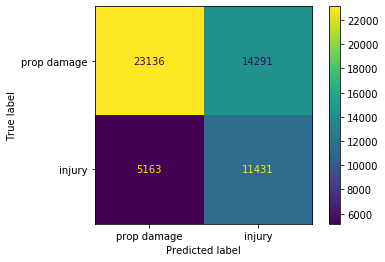

In [257]:
deploy_logisticRegression(X_full_train, y_train_obj, X_full_test, y_test_obj)

{'Accuracy': 0.6733492530682512, 'Presicion': 0.8702504398607419, 'Recall': 0.5972426323242579}
              precision    recall  f1-score   support

 prop damage       0.48      0.79      0.60     16594
      injury       0.87      0.62      0.72     37427

    accuracy                           0.67     54021
   macro avg       0.68      0.71      0.66     54021
weighted avg       0.75      0.67      0.69     54021



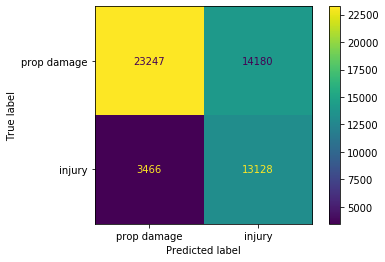

In [258]:
deploy_decisionTree(X_full_train, y_train_obj, X_full_test, y_test_obj)

{'Accuracy': 0.7322892949038337, 'Presicion': 0.7614234000409809, 'Recall': 0.5972426323242579}
              precision    recall  f1-score   support

 prop damage       0.61      0.37      0.46     16594
      injury       0.76      0.89      0.82     37427

    accuracy                           0.73     54021
   macro avg       0.68      0.63      0.64     54021
weighted avg       0.71      0.73      0.71     54021



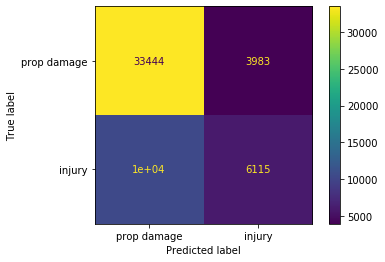

In [259]:
deploy_Gaussian(X_full_train, y_train_obj, X_full_test, y_test_obj)

In [268]:
test = pd.DataFrame(y_test)

In [277]:
test[0].value_counts()

1    37427
0    16594
Name: 0, dtype: int64